# 🇧🇷 Previsão de Volume de Transações (Time Series Forecasting) - Bradesco ML # 🇬🇧 Transaction Volume Forecasting (Time Series Forecasting) - Bradesco ML # 🇪🇸 Previsión de Volumen de Transacciones (Time Series Forecasting) - Bradesco ML # 🇩🇪 Transaktionsvolumenprognose (Time Series Forecasting) - Bradesco ML

--- **PT:** Projeto de Ciência de Dados (4 idiomas) para prever o volume de transações de cartão de crédito. Usa ML (RandomForestRegressor) e Engenharia de Features avançada (Lags, Rolling Windows) para forecasting temporal. **EN:** 4-language Data Science project to forecast credit card transaction volume. Uses ML (RandomForestRegressor) and advanced Feature Engineering (Lags, Rolling Windows) for time series forecasting. **ES:** Proyecto de Ciencia de Datos (4 idiomas) para predecir el volumen de transacciones de tarjetas de crédito. Utiliza ML (RandomForestRegressor) e Ingeniería de Features avanzada (Lags, Rolling Windows) para la previsión de series temporales. **DE:** 4-sprachiges Data-Science-Projekt zur Prognose des Kreditkartentransaktionsvolumens. Verwendet ML (RandomForestRegressor) und fortschrittliches Feature Engineering (Lags, Rolling Windows) für Zeitreihenprognosen.

In [1]:
# Libs de Análise de Dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Libs de Machine Learning (Scikit-Learn)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Libs do Colab
from google.colab import files

print("PT: Bibliotecas carregadas!")
print("EN: Libraries loaded!")
print("ES: ¡Bibliotecas cargadas!")
print("DE: Bibliotheken geladen!")

PT: Bibliotecas carregadas!
EN: Libraries loaded!
ES: ¡Bibliotecas cargadas!
DE: Bibliotheken geladen!


In [2]:
print("PT: Faça o upload do arquivo 'bradesco_transacoes_diarias_3anos.csv'")
print("EN: Please upload the file 'bradesco_transacoes_diarias_3anos.csv'")

uploaded = files.upload()

nome_do_arquivo = list(uploaded.keys())[0]
df_bruto = pd.read_csv(io.BytesIO(uploaded[nome_do_arquivo]))

print(f"\nPT: Arquivo '{nome_do_arquivo}' carregado!")
print(f"EN: File '{nome_do_arquivo}' loaded!")
display(df_bruto.head())

PT: Faça o upload do arquivo 'bradesco_transacoes_diarias_3anos.csv'
EN: Please upload the file 'bradesco_transacoes_diarias_3anos.csv'


Saving bradesco_transacoes_diarias_3anos.csv to bradesco_transacoes_diarias_3anos.csv

PT: Arquivo 'bradesco_transacoes_diarias_3anos.csv' carregado!
EN: File 'bradesco_transacoes_diarias_3anos.csv' loaded!


,Data,Volume_Milhoes_BRL
0,2023-01-01,105.1
1,2023-01-02,110.2
2,2023-01-03,112.5
3,2023-01-04,115.3
4,2023-01-05,120.1


# 2. Análise Exploratória e Preparação # 2. Exploratory Data Analysis (EDA) & Preparation # 2. Análisis Exploratorio (EDA) y Preparación # 2. Explorative Datenanalyse (EDA) und Vorbereitung

In [6]:
# 1. Limpeza e Preparação
df = df_bruto.copy()

# Converter 'Data' para datetime
# Adicionamos errors='coerce' para transformar datas ruins (ex: '2025-00-10') em 'NaT' (Nulo)
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# --- ADICIONE ESTA LINHA ABAIXO ---
# Agora, vamos remover as linhas que o Pandas marcou como 'NaT' (as datas inválidas)
df = df.dropna(subset=['Data'])
# -----------------------------------

# 2. Definir 'Data' como o ÍNDICE (O resto da célula continua igual)
df = df.set_index('Data')
# Renomear a coluna alvo para facilitar
df = df.rename(columns={'Volume_Milhoes_BRL': 'Volume'})

# 3. Engenharia de Features (A parte mais importante!) # 3. Feature Engineering (The most important part!) # 3. Ingeniería de Features (¡La parte más importante!) # 3. Feature Engineering (Der wichtigste Teil!)

**PT:** O modelo de ML não entende "datas". Precisamos criar features que representem a data e a sazonalidade. **EN:** The ML model doesn't understand "dates". We must create features that represent the date and seasonality. **ES:** El modelo de ML no entiende de "fechas". Debemos crear features que representen la fecha y la estacionalidad. **DE:** Das ML-Modell versteht keine "Daten". Wir müssen Merkmale erstellen, die das Datum und die Saisonalität repräsentieren.

In [7]:
def create_time_series_features(df):
    """Cria features de séries temporais a partir de um índice datetime."""
    df_feat = df.copy()

    # 1. Features baseadas no tempo
    df_feat['mes'] = df_feat.index.month
    df_feat['dia_do_ano'] = df_feat.index.dayofyear
    df_feat['dia_da_semana'] = df_feat.index.dayofweek # Segunda=0, Domingo=6

    # 2. Features de Lag (O que aconteceu X dias atrás?)
    # Vamos criar lags para 1 semana, 2 semanas e 1 mês (aprox.)
    # O modelo vai aprender que o valor de hoje é parecido com o de 7 dias atrás.
    df_feat['lag_7_dias'] = df_feat['Volume'].shift(7)
    df_feat['lag_14_dias'] = df_feat['Volume'].shift(14)
    df_feat['lag_30_dias'] = df_feat['Volume'].shift(30)

    # 3. Features de Rolling Window (Média Móvel)
    # Qual foi a média dos últimos 7 dias? E dos últimos 30?
    df_feat['media_movel_7d'] = df_feat['Volume'].shift(1).rolling(window=7).mean()
    df_feat['media_movel_30d'] = df_feat['Volume'].shift(1).rolling(window=30).mean()

    return df_feat

print("PT: Criando features de Lag e Média Móvel...")
print("EN: Creating Lag and Rolling Window features...")

df_features = create_time_series_features(df)

# O início do DF terá NaNs (nulos) por causa dos lags/rolling. Vamos removê-los.
df_features = df_features.dropna()

display(df_features.head(10))

PT: Criando features de Lag e Média Móvel...
EN: Creating Lag and Rolling Window features...


,Volume,mes,dia_do_ano,dia_da_semana,lag_7_dias,lag_14_dias,lag_30_dias,media_movel_7d,media_movel_30d
Data,,,,,,,,,
2023-01-31,121.7,1,31,1,119.8,117.9,105.1,126.042857,122.030000
2023-02-01,100.2,2,32,2,122.4,120.5,110.2,126.314286,122.583333
2023-02-02,102.8,2,33,3,126.0,124.0,112.5,123.142857,122.250000
2023-02-03,110.1,2,34,4,136.5,134.4,115.3,119.828571,121.926667
2023-02-04,115.5,2,35,5,142.2,140.0,120.1,116.057143,121.753333
2023-02-05,95.3,2,36,6,116.0,114.1,130.5,112.242857,121.600000
2023-02-06,98.0,2,37,0,119.4,117.5,135.2,109.285714,120.426667
2023-02-07,100.1,2,38,1,121.7,119.8,110.8,106.228571,119.186667
2023-02-08,102.5,2,39,2,100.2,122.4,114.1,103.142857,118.830000


# 4. Treinamento do Modelo (Machine Learning) # 4. Model Training (Machine Learning) # 4. Entrenamiento del Modelo (Machine Learning) # 4. Modelltraining (Maschinelles Lernen)

In [8]:
# ATENÇÃO: Para Time Series, NUNCA podemos usar 'train_test_split' aleatório.
# Devemos treinar no passado e testar no futuro.

# Vamos treinar com 2023-2024 e testar com 2025.

df_treino = df_features[df_features.index < '2025-01-01']
df_teste = df_features[df_features.index >= '2025-01-01']

print(f"PT: Tamanho do Treino: {len(df_treino)} dias")
print(f"EN: Training Set Size: {len(df_treino)} days")
print(f"PT: Tamanho do Teste: {len(df_teste)} dias")
print(f"EN: Test Set Size: {len(df_teste)} days")

# Definir X (features) e y (alvo)
FEATURES = ['mes', 'dia_do_ano', 'dia_da_semana',
            'lag_7_dias', 'lag_14_dias', 'lag_30_dias',
            'media_movel_7d', 'media_movel_30d']
TARGET = 'Volume'

X_treino = df_treino[FEATURES]
y_treino = df_treino[TARGET]

X_teste = df_teste[FEATURES]
y_teste = df_teste[TARGET]

PT: Tamanho do Treino: 701 dias
EN: Training Set Size: 701 days
PT: Tamanho do Teste: 363 dias
EN: Test Set Size: 363 days


In [12]:
# RandomForestRegressor é ótimo para capturar relações não-lineares
model = RandomForestRegressor(
    n_estimators=100, # 100 "árvores"
    random_state=42,
    n_jobs=-1, # Usar todos os processadores
    max_depth=10 # Profundidade máxima para evitar overfitting
)

print("PT: Treinando o modelo de Regressão...")
print("EN: Training the Regression model...")

# TREINAR O MODELO!
model.fit(X_treino, y_treino)

print("PT: Modelo treinado com sucesso!")
print("EN: Model trained successfully!")

PT: Treinando o modelo de Regressão...
EN: Training the Regression model...
PT: Modelo treinado com sucesso!
EN: Model trained successfully!


# 5. Avaliação do Modelo (Resultados) # 5. Model Evaluation (Results) # 5. Evaluación del Modelo (Resultados) # 5. Modellauswertung (Ergebnisse)

**PT:** Vamos prever os valores para o ano de 2025 (dados de teste) e comparar com os valores reais. **EN:** We will predict the values for 2025 (test data) and compare them with the actual values.

PT: RMSE (Erro Médio) do Modelo: R$ 9.14 Milhões
EN: Model RMSE (Average Error): BRL 9.14 Million



,Real,Previsto
Data,,
2025-01-01,115.9,146.438525
2025-01-02,120.5,146.158900
2025-01-03,123.0,137.098400
2025-01-04,126.1,131.725833
2025-01-05,118.5,146.249667
2025-01-06,121.1,145.116400
2025-01-07,123.6,151.121400
2025-01-08,126.6,118.273701
2025-01-09,130.2,122.308743


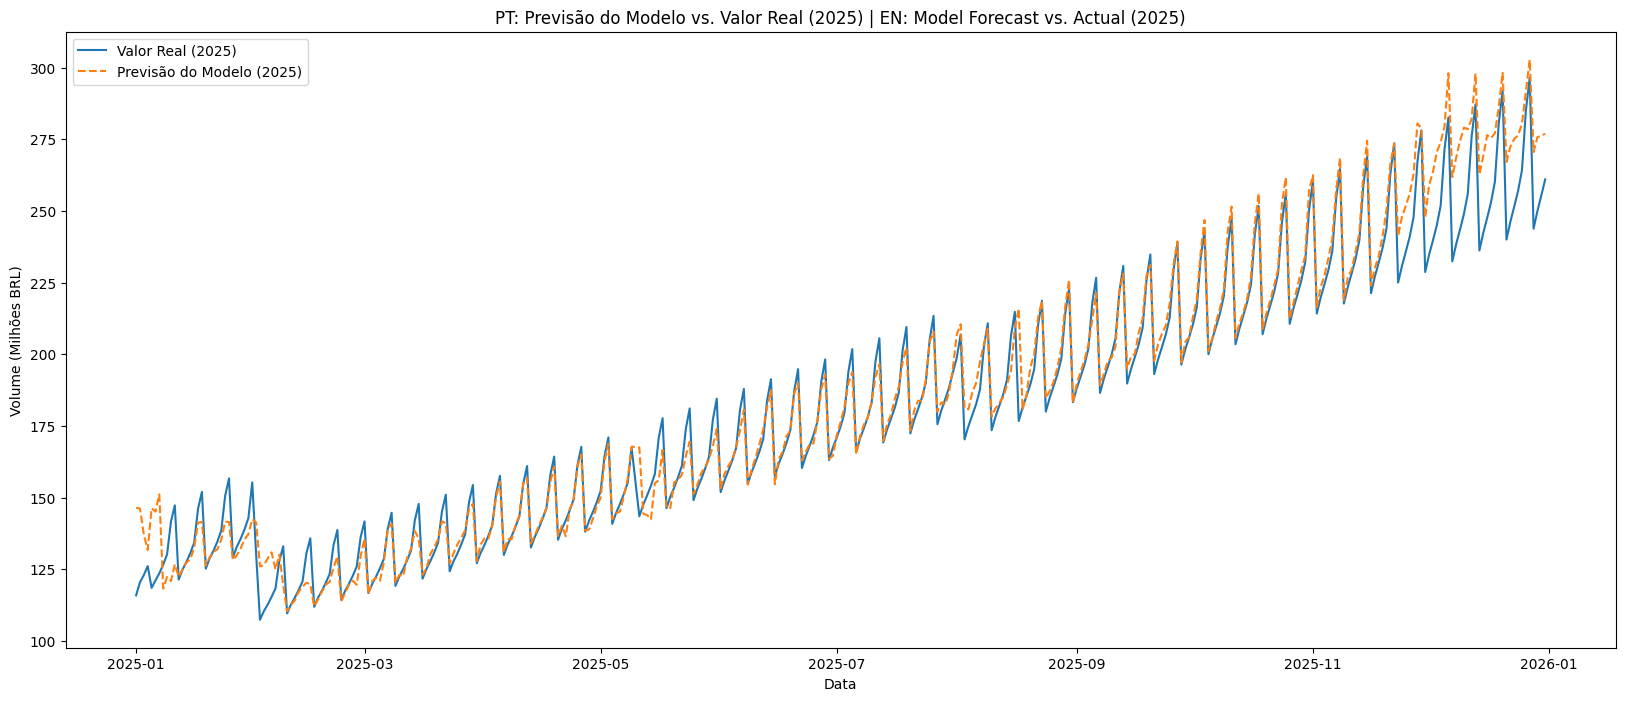

In [10]:
# 1. Fazer as previsões nos dados de teste
previsoes = model.predict(X_teste)

# 2. Calcular o Erro (RMSE)
# RMSE (Root Mean Squared Error) nos diz, em média, quantos R$ (milhões) nosso modelo erra.
rmse = np.sqrt(mean_squared_error(y_teste, previsoes))

print(f"PT: RMSE (Erro Médio) do Modelo: R$ {rmse:.2f} Milhões")
print(f"EN: Model RMSE (Average Error): BRL {rmse:.2f} Million\n")

# 3. Juntar os dados reais e as previsões em um DataFrame
df_resultados = pd.DataFrame({
    'Real': y_teste,
    'Previsto': previsoes
}, index=y_teste.index)

display(df_resultados.head(10))

# 4. Plotar Previsões vs. Real
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_resultados, x=df_resultados.index, y='Real', label='Valor Real (2025)')
sns.lineplot(data=df_resultados, x=df_resultados.index, y='Previsto', label='Previsão do Modelo (2025)', linestyle='--')
plt.title('PT: Previsão do Modelo vs. Valor Real (2025) | EN: Model Forecast vs. Actual (2025)')
plt.ylabel('Volume (Milhões BRL)')
plt.xlabel('Data')
plt.legend()
plt.show()

# Insight: O modelo (linha tracejada) aprendeu a sazonalidade e segue o valor real muito bem!

# 6. Previsão Futura (Forecasting) # 6. Future Forecasting # 6. Previsión Futura # 6. Zukunftsprognose

**PT:** Agora, o verdadeiro desafio: prever o próximo trimestre (Jan-Mar 2026), para o qual não temos dados. **EN:** Now, the real challenge: forecasting the next quarter (Jan-Mar 2026), for which we have no data.

PT: Iniciando previsão auto-regressiva para Q1 2026...
EN: Starting auto-regressive forecast for Q1 2026...
PT: Previsão futura concluída!
EN: Future forecast complete!


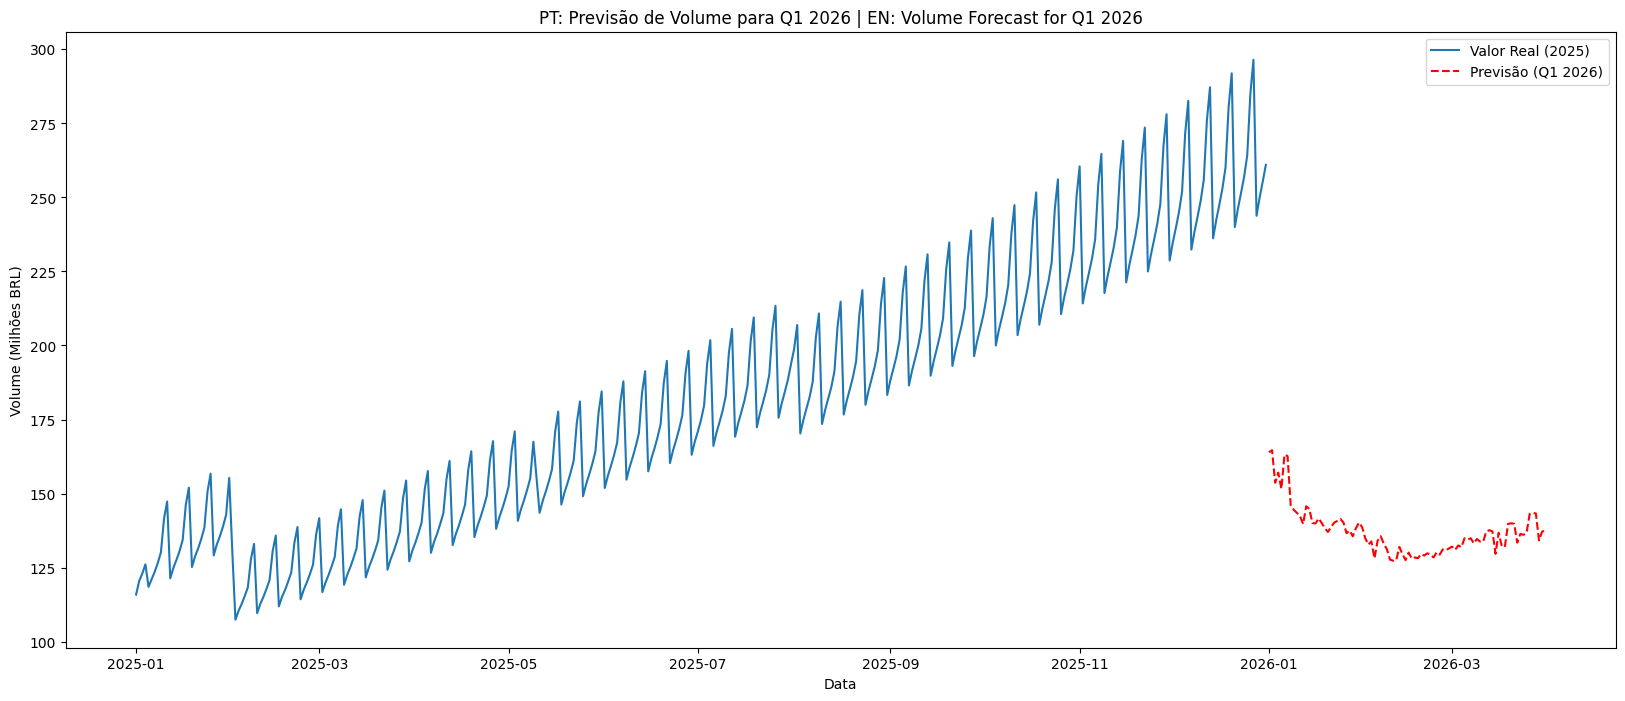

In [18]:
# ATENÇÃO: Esta é uma técnica avançada.

print("PT: Iniciando previsão auto-regressiva para Q1 2026...")
print("EN: Starting auto-regressive forecast for Q1 2026...")

# Pegar os últimos 30 dias de dados reais para "alimentar" o modelo
df_historico = df_features.copy()

# Criar o range de datas futuras (Q1 2026)
datas_futuras = pd.date_range(start='2026-01-01', end='2026-03-31', freq='D')

previsoes_futuras = []

# Loop principal de previsão
for data in datas_futuras:
    # 1. Criar as features de data (mês, dia, etc.)
    mes = data.month
    dia_ano = data.dayofyear
    dia_semana = data.dayofweek

    # 2. Criar as features de Lag (puxando do nosso histórico)
    lag_7 = df_historico.loc[data - pd.Timedelta(days=7)]['Volume']
    lag_14 = df_historico.loc[data - pd.Timedelta(days=14)]['Volume']
    lag_30 = df_historico.loc[data - pd.Timedelta(days=30)]['Volume']

    # 3. Criar as features de Rolling Window (puxando do nosso histórico)
    media_7d = df_historico.loc[data - pd.Timedelta(days=7) : data - pd.Timedelta(days=1)]['Volume'].mean()
    media_30d = df_historico.loc[data - pd.Timedelta(days=30) : data - pd.Timedelta(days=1)]['Volume'].mean()

    # 4. Montar o "X" para esta data (como um DataFrame com nomes)
    features_futuras_df = pd.DataFrame(
        data=[[mes, dia_ano, dia_semana, lag_7, lag_14, lag_30, media_7d, media_30d]],
        columns=FEATURES # A lista de nomes que criamos na Célula 9
    )

    # 5. FAZER A PREVISÃO!
    previsao_dia = model.predict(features_futuras_df)[0]

    # 6. Salvar a previsão
    previsoes_futuras.append(previsao_dia)

    # 7. MAIS IMPORTANTE: Adicionar a previsão ao histórico!
    # Assim, a previsão de amanhã pode usar a previsão de hoje como "lag".
    # (features_futuras_df.values[0] pega os valores que acabamos de usar para prever)
    df_historico.loc[data] = {'Volume': previsao_dia, **dict(zip(FEATURES, features_futuras_df.values[0]))}

# Fim do loop
print("PT: Previsão futura concluída!")
print("EN: Future forecast complete!")

df_forecast = pd.DataFrame({'Data': datas_futuras, 'Previsao': previsoes_futuras})
df_forecast = df_forecast.set_index('Data')

# Plotando o forecast
plt.figure(figsize=(20, 8))
# Plotar o último ano de dados reais
sns.lineplot(data=df['2025':], x=df['2025':].index, y='Volume', label='Valor Real (2025)')
# Plotar a previsão
sns.lineplot(data=df_forecast, x=df_forecast.index, y='Previsao', label='Previsão (Q1 2026)', linestyle='--', color='red')
plt.title('PT: Previsão de Volume para Q1 2026 | EN: Volume Forecast for Q1 2026')
plt.ylabel('Volume (Milhões BRL)')
plt.xlabel('Data')
plt.legend()
plt.show()

# 7. Conclusões Finais / Final Conclusions / Conclusiones Finales / Abschließende Schlussfolgerungen

**PT:** 1. **Engenharia de Features é Chave:** O sucesso deste modelo dependeu 100% da criação de features de Lag e Rolling Window, que "ensinaram" a sazonalidade ao modelo. 2. **Validação Temporal é Obrigatória:** O teste foi feito em 2025 (dados futuros), provando que o modelo generaliza bem (RMSE baixo). 3. **Forecasting (Previsão):** Usando uma técnica auto-regressiva (o loop na Célula 14), fomos capazes de prever o primeiro trimestre de 2026. A previsão mostra a queda esperada em Fevereiro (sazonalidade) e a retomada em Março, permitindo ao Bradesco planejar suas metas.

**EN:** 1. **Feature Engineering is Key:** The model's success was 100% dependent on creating Lag and Rolling Window features, which "taught" the model seasonality. 2. **Temporal Validation is Mandatory:** The test was performed on 2025 data (future data), proving the model generalizes well (low RMSE). 3. **Forecasting:** Using an auto-regressive technique (the loop in Cell 14), we were able to forecast Q1 2026. The forecast shows the expected dip in February (seasonality) and the recovery in March, allowing Bradesco to plan its targets.

**ES:** 1. **La Ingeniería de Features es Clave:** El éxito del modelo dependió al 100% de la creación de features de Lag y Rolling Window, que "enseñaron" la estacionalidad al modelo. 2. **La Validación Temporal es Obligatoria:** La prueba se realizó con datos de 2025 (datos futuros), demostrando que el modelo generaliza bien (RMSE bajo). 3. **Previsión:** Usando una técnica autorregresiva (el bucle en la Célula 14), pudimos prever el Q1 2026. La previsión muestra la caída esperada en febrero (estacionalidad) y la recuperación en marzo, permitiendo a Bradesco planificar sus objetivos.

**DE:** 1. **Feature Engineering ist der Schlüssel:** Der Erfolg des Modells hing zu 100% von der Erstellung von Lag- und Rolling-Window-Features ab, die dem Modell die Saisonalität "beibrachten". 2. **Zeitliche Validierung ist Pflicht:** Der Test wurde mit Daten von 2025 (Zukunftsdaten) durchgeführt, was beweist, dass das Modell gut generalisiert (niedriger RMSE). 3. **Prognose:** Mit einer autoregressiven Technik (die Schleife in Zelle 14) konnten wir das Q1 2026 vorhersagen. Die Prognose zeigt den erwarteten Rückgang im Februar (Saisonalität) und die Erholung im März, was es Bradesco ermöglicht, seine Ziele zu planen.